In [1]:
import argparse
import os
import sys
import joblib
from joblib import Parallel, delayed
output_stream = sys.stdout
import cvxpy as cp
import scipy as sc
import numpy as np
import numpy.random as npr
import torch
from sklearn import datasets
import pandas as pd
import lropt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes
import warnings
warnings.filterwarnings("ignore")

In [2]:
def gen_sigmu(n,seed = 0):
    np.random.seed(seed)
    F = np.random.normal(size = (n,2))
    sig = 0.1*F@(F.T)
    mu = np.random.uniform(0.5,1,n)
    return sig, mu

def gen_demand(sig,mu,N,seed=399):
    np.random.seed(seed)
    d_train = np.random.multivariate_normal(mu,sig, N)
    return d_train


In [3]:
def gen_sigmu_varied(n,N = 500,seed = 0):
    np.random.seed(seed)
    sig = []
    context = []
    mu = []
    origmu = np.random.uniform(0.5,1,n)
    for i in range(N):
        F = np.random.normal(size = (n,2))
        context.append(F)
        csig = 0.2*F@(F.T)
        sig.append(csig)
        mu.append(np.random.uniform(0.5,1,n))
    return np.stack(sig), np.vstack(mu), np.stack(context), origmu

def gen_demand_varied(sig,mu,orig_mu,N,seed=399):
    pointlist = []
    np.random.seed(seed)
    for i in range(N):
        d_train = np.random.multivariate_normal(0.7*orig_mu+ 0.3*mu[i],sig[i]+0.1*np.eye(orig_mu.shape[0]))
        pointlist.append(d_train)
    return np.vstack(pointlist)

In [4]:
foldername = "/Users/irina.wang/Desktop/Princeton/Project2/lropt_experiments/lropt_experiments/portfolio_exp/"
N =2000
num_context = 20
R = 1
n = 30
test_p = 0.5
# sig, mu = gen_sigmu(n,1)
num_reps = int(N/num_context)
sig, mu, context, orig_mu = gen_sigmu_varied(n,num_context,seed= 0)
sig = np.vstack([sig]*num_reps)
mu = np.vstack([mu]*num_reps)
context = np.vstack([context]*num_reps)
np.random.seed(5)
test_valid_indices = np.random.choice(N,int((test_p+0.2)*N), replace=False)
test_indices = test_valid_indices[:int((test_p)*N)]
valid_indices = test_valid_indices[int((test_p)*N):]
train_indices = [i for i in range(N) if i not in test_valid_indices]
context_train = context[train_indices]
mu_train = mu[train_indices]
data = gen_demand_varied(sig,mu,orig_mu,N,seed=0)
train = data[train_indices]
# np.random.seed(seed)
# dist = mu
# y_nom = np.random.dirichlet(dist)
r = 0
eta = 0.3
seed = r + 10

In [5]:
context_inds = {}
test_inds = {}
for j in range(num_context):
  context_inds[j]= [i for i in train_indices + list([*valid_indices]) if j*num_reps <= i <= (j+1)*num_reps]
  test_inds[j] = [i for i in test_indices if j*num_reps <= i <= (j+1)*num_reps]

In [6]:
def calc_eval(x,t,u):
    val = 0
    vio = 0
    for i in range(u.shape[0]):
        val_cur = -x@u[i]
        val+= val_cur
        vio += (val_cur >= t)
    return val/u.shape[0], vio/u.shape[0]

context_evals = 0
context_probs = 0
for j in range(num_context):
    u = lropt.UncertainParameter(n,
                            uncertainty_set=lropt.Scenario(
                                                        data=data[context_inds[j]]))
    # Formulate the Robust Problem
    x_s = cp.Variable(n)
    t_s = cp.Variable()

    objective = cp.Minimize(t_s)
    constraints = [-x_s@u <= t_s, cp.sum(x_s) == 1, x_s >= 0]
    prob_context = lropt.RobustProblem(objective, constraints)
    prob_context.solve()
    eval, prob_vio = calc_eval(x_s.value, t_s.value,data[test_inds[j]])
    context_evals += eval
    context_probs += prob_vio
context_evals = context_evals/num_context
context_probs = context_probs/num_context

In [7]:
nonrob_evals = 0
nonrob_probs = 0
for j in range(num_context):
    u = lropt.UncertainParameter(n,
                            uncertainty_set=lropt.Scenario(
                                                        data=np.mean(data[context_inds[j]],axis=0).reshape(1,n)))
    # Formulate the Robust Problem
    x_s = cp.Variable(n)
    t_s = cp.Variable()

    objective = cp.Minimize(t_s)
    constraints = [-x_s@u <= t_s, cp.sum(x_s) == 1, x_s >= 0]
    prob_nonrob = lropt.RobustProblem(objective, constraints)
    prob_nonrob.solve()
    eval, prob_vio = calc_eval(x_s.value, t_s.value,data[test_inds[j]])
    nonrob_evals += eval
    nonrob_probs += prob_vio
nonrob_evals = nonrob_evals / (num_context)
nonrob_probs = nonrob_probs / (num_context)

In [8]:
data_gen = False
while not data_gen:
    try: 
        data = gen_demand_varied(sig,mu,orig_mu,N,seed=seed)
        train = data[train_indices]
        init = sc.linalg.sqrtm(np.cov(train.T))
    except Exception as e:
        seed += 1
    else: 
        data_gen = True
# y_data = np.maximum(y_nom + np.random.normal(0,0.05,(10,n)),0.001)
# y_data = np.diag(1/np.sum(y_data, axis=1))@y_data
# y_data = np.vstack([y_data]*num_reps)

init_bval = np.mean(train, axis=0)
        
# u = lropt.UncertainParameter(n,
#                         uncertainty_set=lropt.Ellipsoidal(p=2,
#                                                     data=data))
u = lropt.UncertainParameter(n,
                            uncertainty_set=lropt.MRO(K=50, p=2, data=data,train_data = train, train=True))
# Formulate the Robust Problem
x = cp.Variable(n)
t = cp.Variable()
context_param = lropt.ContextParameter((n,2), data=context)
mu_param = lropt.ContextParameter(n, data=mu)

# objective = cp.Minimize(t + 0.2*cp.norm(x - y, 1))
# constraints = [-x@u <= t, cp.sum(x) == 1, x >= 0]
# eval_exp = -x @ u + 0.2*cp.norm(x-y, 1)

objective = cp.Minimize(t)
constraints = [-x@u <= t, cp.sum(x) == 1, x >= 0]
constraints += [context_param >= -1000, mu_param >= -1000]
eval_exp = -x @ u

prob = lropt.RobustProblem(objective, constraints, eval_exp=eval_exp)
s = seed

# Train A and b
trainer = lropt.Trainer(prob)
settings = lropt.TrainerSettings()
settings.predictor = lropt.LinearPredictor(predict_mean = True,pretrain=False, lr=0.01,epochs = 500,knn_cov = False,n_neighbors=20, knn_scale = 0.8)
settings.initialize_predictor = True
# settings.predictor = lropt.CovPredictor()
settings.set(lr=0.01, num_iter=1, optimizer="SGD",
                    seed=s, init_A=init, init_b=init_bval, init_lam=1, init_mu=1,
                    mu_multiplier=1.005, init_alpha=0., test_percentage = test_p, test_frequency = 2000, validate_frequency=10,max_batch_size = 100, batch_percentage = 0.2, save_history = False, lr_step_size = 50, lr_gamma = 0.5, position = False, random_init = False, eta = eta, kappa=0.0,contextual = True,obj_scale = 0.5,init_rho = 1,parallel = False)
# result = trainer.train(settings=settings)
# df = result.df
# A_fin = result.A
# b_fin = result.b

In [9]:
eps_list=np.linspace(0.5, 10, 20)
settings.data = data
result_grid = trainer.grid(rholst=eps_list, init_A=np.eye(n),
                    init_b=np.zeros(n), seed=5,
                    init_alpha=0., test_percentage=0.5, validate_percentage = 0.2, quantiles = (0.3, 0.7),settings = settings)
dfgrid = result_grid.df

In [109]:
settings.predictor = result.predictor
criterion = torch.nn.MSELoss()
ahat,yhat=trainer.create_predictor_tensors(trainer.x_train_tch)
loss = criterion(yhat,trainer.u_train_tch)
loss, criterion(yhat,torch.mean(trainer.u_train_tch,axis=0)),criterion(ahat,torch.tensor(sig[train_indices])),criterion(torch.tensor(init),torch.tensor(sig[train_indices])),criterion(trainer.u_train_tch,torch.mean(trainer.u_train_tch,axis=0))

# for i in range(10):
#     plt.plot((0.7*orig_mu+ 0.3*mu[train_indices])[i])
#     plt.plot(b_tch[i].detach().numpy())
#     plt.plot(np.mean(trainer.u_train_set,axis = 0))
#     plt.show()

(tensor(0.4714, grad_fn=<MseLossBackward0>),
 tensor(0.0360, grad_fn=<MseLossBackward0>),
 tensor(0.0728, grad_fn=<MseLossBackward0>),
 tensor(0.0677),
 tensor(0.4637, grad_fn=<MseLossBackward0>))

In [110]:
# plt.plot(ahat[40].detach().numpy().flatten())
# plt.plot(init.flatten())
# plt.plot(sig[40].flatten())

In [14]:
epslst=np.linspace(0.5, 10, 20)
result5 = trainer.grid(rholst=epslst, init_A=A_fin, init_b=b_fin, init_rho = result.rho, seed=s, init_alpha=0., test_percentage=test_p,contextual = True, predictor = result.predictor )
dfgrid2 = result5.df

In [119]:
result4 = trainer.grid(rholst=epslst, init_A=init,
                    init_b=init_bval, seed=s,
                    init_alpha=0., test_percentage=test_p,eta=eta)
dfgrid = result4.df

settings.num_iter = 1
settings.initialize_predictor = True
settings.predictor = lropt.LinearPredictor(predict_mean = True,pretrain=False, lr=0.001,epochs = 100,knn_cov = True, n_neighbors=75,knn_scale = 1)
# settings.predictor = lropt.CovPredictor()
result2 = trainer.train(settings=settings)
result6 = trainer.grid(rholst=epslst, init_A=result2.A, init_b=result2.b, init_rho = result2.rho, seed=s, init_alpha=0., test_percentage=test_p,contextual = True, predictor = result2._predictor )
dfgrid3 = result6.df

# dfgrid.to_csv(foldername + f"gridmv_{N,n,r}.csv")
# dfgrid2.to_csv(foldername +f"gridre_{N,n,r}.csv")
# dfgrid3.to_csv(foldername +f"gridpre_{N,n,r}.csv")
# result.df_test.to_csv(foldername +f"trainval_{N,n,r}.csv")
# result.df.to_csv(foldername +f"train_{N,n,r}.csv")

Training:   0%|          | 0/1 [00:07<?, ?it/s]


In [113]:
df_valid, df_test = trainer.compare_predictors(settings=settings,predictors_list = [result.predictor], rho_list=[result.rho])

Training:   0%|          | 0/1 [00:07<?, ?it/s]


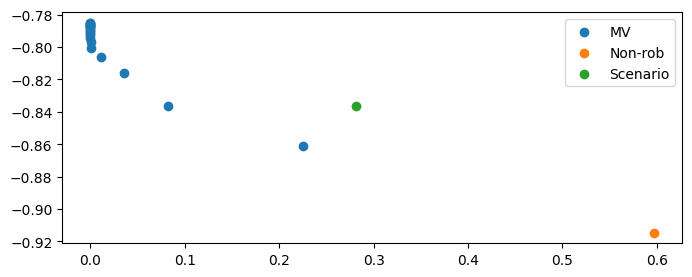

In [10]:
plt.figure(figsize = (8,3))
plt.scatter(dfgrid["Avg_prob_test"],dfgrid["Test_val"],label = "MV")
# plt.scatter(dfgrid2["Avg_prob_test"],dfgrid2["Test_val"],label = "Trained")
# plt.scatter(dfgrid3["Avg_prob_test"],dfgrid3["Test_val"],label = "Pretrained")
# plt.scatter(df_test["Avg_prob_test"],df_test["Test_val"])
plt.scatter(nonrob_probs,nonrob_evals,label = "Non-rob")
plt.scatter(context_probs,context_evals,label = "Scenario")
plt.legend()
plt.show()

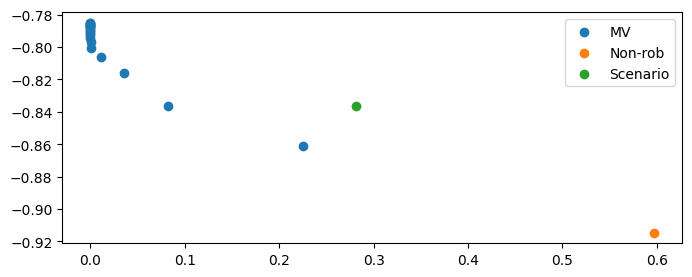

In [12]:
plt.figure(figsize = (8,3))
plt.scatter(dfgrid["Avg_prob_test"],dfgrid["Test_val"],label = "MV")
# plt.scatter(dfgrid2["Avg_prob_test"],dfgrid2["Test_val"],label = "Trained")
# plt.scatter(dfgrid3["Avg_prob_test"],dfgrid3["Test_val"],label = "Pretrained")
# plt.scatter(df_test["Avg_prob_test"],df_test["Test_val"])
plt.scatter(nonrob_probs,nonrob_evals,label = "Non-rob")
plt.scatter(context_probs,context_evals,label = "Scenario")
plt.legend()
plt.show()

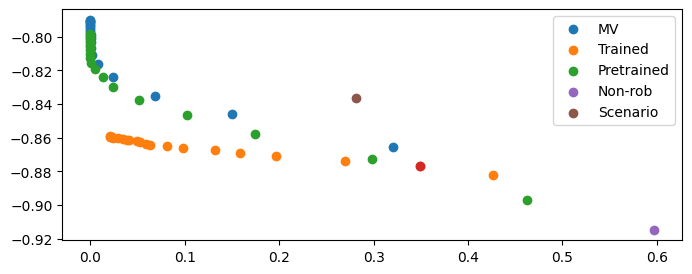

In [ ]:
plt.figure(figsize = (8,3))
plt.scatter(dfgrid["Avg_prob_test"],dfgrid["Test_val"],label = "MV")
plt.scatter(dfgrid2["Avg_prob_test"],dfgrid2["Test_val"],label = "Trained")
plt.scatter(dfgrid3["Avg_prob_test"],dfgrid3["Test_val"],label = "Pretrained")
plt.scatter(df_test["Avg_prob_test"],df_test["Test_val"])
plt.scatter(nonrob_probs,nonrob_evals,label = "Non-rob")
plt.scatter(context_probs,context_evals,label = "Scenario")
plt.legend()
plt.show()

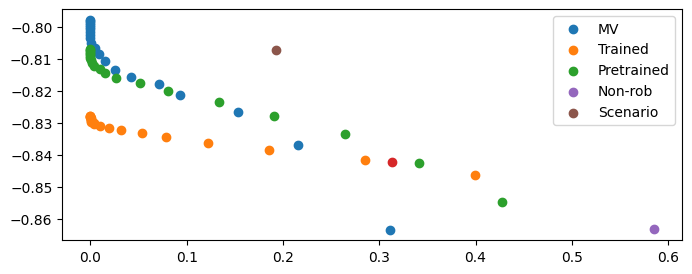

In [35]:
plt.figure(figsize = (8,3))
plt.scatter(dfgrid["Avg_prob_test"],dfgrid["Test_val"],label = "MV")
plt.scatter(dfgrid2["Avg_prob_test"],dfgrid2["Test_val"],label = "Trained")
plt.scatter(dfgrid3["Avg_prob_test"],dfgrid3["Test_val"],label = "Pretrained")
plt.scatter(df_test["Avg_prob_test"],df_test["Test_val"])
plt.scatter(nonrob_probs,nonrob_evals,label = "Non-rob")
plt.scatter(context_probs,context_evals,label = "Scenario")
plt.legend()
plt.show()

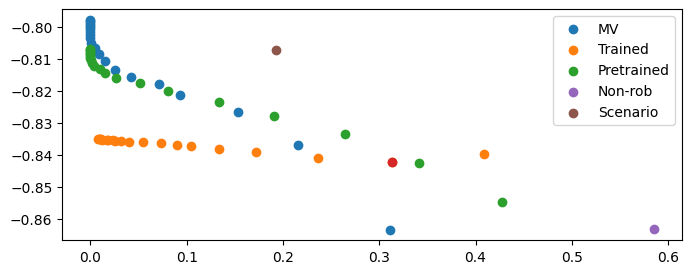

In [27]:
plt.figure(figsize = (8,3))
plt.scatter(dfgrid["Avg_prob_test"],dfgrid["Test_val"],label = "MV")
plt.scatter(dfgrid2["Avg_prob_test"],dfgrid2["Test_val"],label = "Trained")
plt.scatter(dfgrid3["Avg_prob_test"],dfgrid3["Test_val"],label = "Pretrained")
plt.scatter(df_test["Avg_prob_test"],df_test["Test_val"])
plt.scatter(nonrob_probs,nonrob_evals,label = "Non-rob")
plt.scatter(context_probs,context_evals,label = "Scenario")
plt.legend()
plt.show()

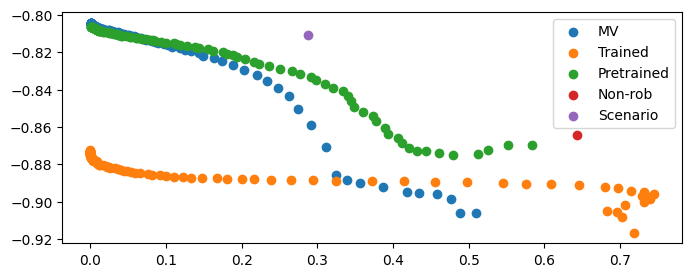

In [22]:
plt.figure(figsize = (8,3))
plt.scatter(dfgrid["Avg_prob_test"],dfgrid["Test_val"],label = "MV")
plt.scatter(dfgrid2["Avg_prob_test"],dfgrid2["Test_val"],label = "Trained")
plt.scatter(dfgrid3["Avg_prob_test"],dfgrid3["Test_val"],label = "Pretrained")
# plt.scatter(df_test["Avg_prob_test"],df_test["Test_val"])
plt.scatter(nonrob_probs,nonrob_evals,label = "Non-rob")
plt.scatter(context_probs,context_evals,label = "Scenario")
plt.legend()
plt.show()

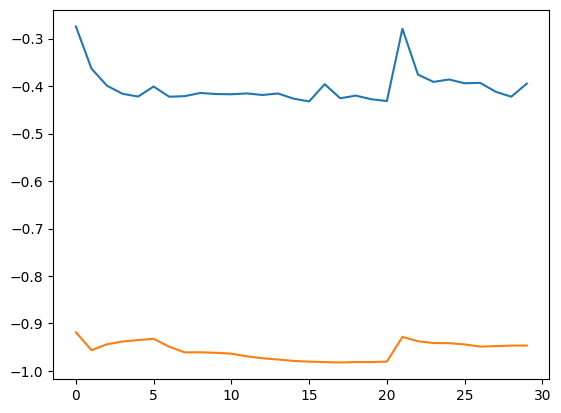

In [33]:
# plt.plot(result.df_validate["Validate_val"])
# plt.plot(result.df_validate["Avg_prob_validate"])
plt.plot(result.df["Lagrangian_val"])
plt.plot(result.df["Train_val"])

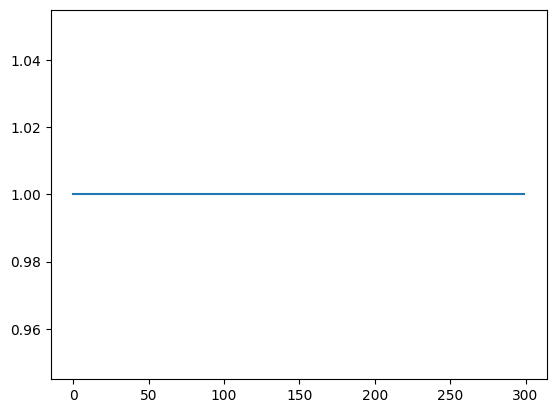

In [14]:
plt.plot(result.df["Rho"])

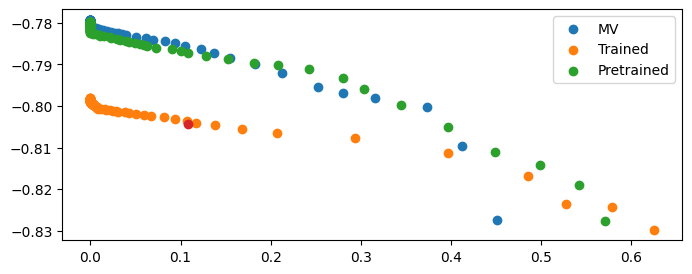

In [32]:
plt.figure(figsize = (8,3))
plt.scatter(dfgrid["Avg_prob_test"],dfgrid["Test_val"],label = "MV")
plt.scatter(dfgrid2["Avg_prob_test"],dfgrid2["Test_val"],label = "Trained")
plt.scatter(dfgrid3["Avg_prob_test"],dfgrid3["Test_val"],label = "Pretrained")
plt.scatter(df_test["Avg_prob_test"],df_test["Test_val"])
plt.legend()
plt.show()

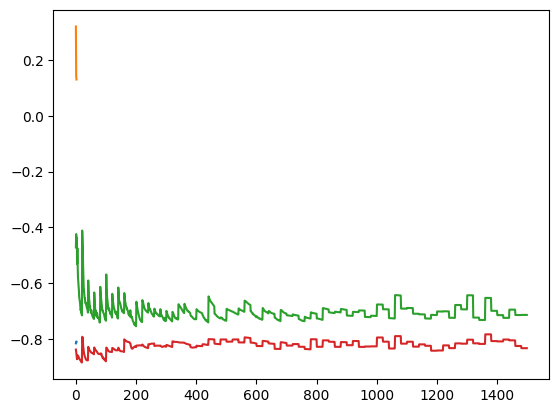

In [121]:
plt.plot(result.df_validate["Validate_val"])
plt.plot(result.df_validate["Avg_prob_validate"])
plt.plot(result.df["Lagrangian_val"])
plt.plot(result.df["Train_val"])

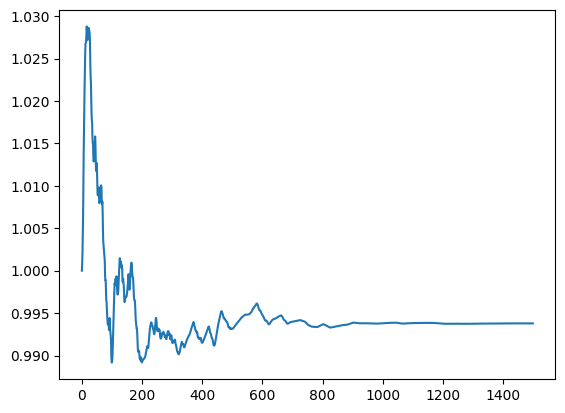

In [122]:
plt.plot(result.df["Rho"])